# Inflation persistance

Test the first hypothesis that IT regime has bring down not only the average inflation but also its persistance. 

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

## Data loading and preprocessing

In [2]:
inf1 = pd.read_csv('data/inflation.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date, format='%d/%m/%Y')
inf1 = inf1.drop("date", axis = 1)
inf1['v_cpi'] = inf1['CPI'].pct_change(12)*100
inf1['vol_cpi1'] = inf1['CPI'].rolling(12).std()
# inf1.head()

In [3]:

from fredapi import Fred
fred = Fred(api_key='ca6ea25f72db47e2d070a76b7e9e639b')
CorePCE = fred.get_series('PCEPILFE')
PCE = fred.get_series('PCEPI')
CpiUS = fred.get_series('CPIAUCSL')
inf1['pce'] = PCE.pct_change(12)*100
inf1['core_pce'] = CorePCE.pct_change(12)*100
inf1['cpiUS'] = CpiUS.pct_change(12)*100


In [4]:
simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

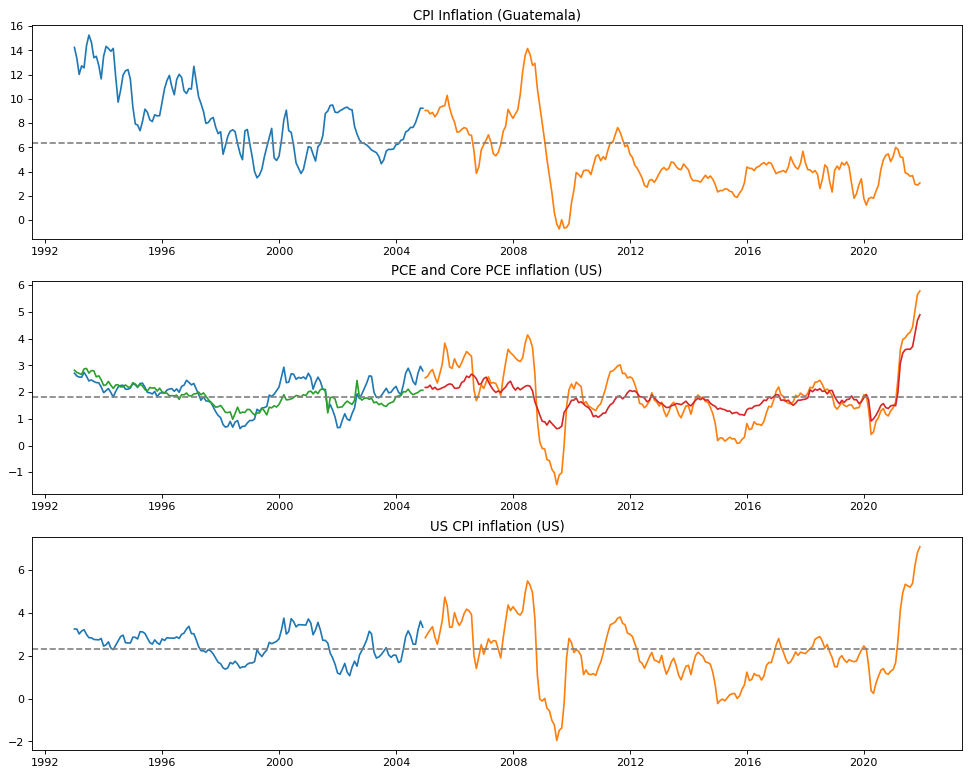

In [5]:
# Ploting the data
fig, axes = plt.subplots(3, 1, figsize=(15,12), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation (Guatemala)')
axes[0].axhline(y=np.mean(simdf['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['pce'])
axes[1].plot(itdf['pce'])
axes[1].plot(predf['core_pce'])
axes[1].plot(itdf['core_pce'])
axes[1].set_title('PCE and Core PCE inflation (US)')
axes[1].axhline(y=np.mean(simdf['core_pce']), color='grey', linestyle='--')

axes[2].plot(predf['cpiUS'])
axes[2].plot(itdf['cpiUS'])
axes[2].set_title('US CPI inflation (US)')
axes[2].axhline(y=np.mean(simdf['cpiUS']), color='grey', linestyle='--')



ADF Test for Stationarity on Guatemala and US inflation

Whole period and subsets

In [6]:
# US PCE Inflation
# Whole period
adf = adfuller(simdf['cpiUS'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['cpiUS'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['cpiUS'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.020210963716462575 , whole period: Series is Stationary
p value:0.16227054660260898 , Series is Non-Stationary
p value:0.1520769544928101 , Series is Non-Stationary


In [7]:
# US PCE Inflation
# Whole period
adf = adfuller(simdf['pce'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['pce'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['pce'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.016100008164943048 , whole period: Series is Stationary
p value:0.24934158485261249 , Series is Non-Stationary
p value:0.17152570376243248 , Series is Non-Stationary


In [8]:
# US core PCE Inflation
# Whole period
adf = adfuller(simdf['core_pce'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['core_pce'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['core_pce'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.24176676444379852 , Series is Non-Stationary
p value:0.3279423279579085 , Series is Non-Stationary
p value:0.8183898194564008 , Series is Non-Stationary


In [9]:
# ADF Test for Stationarity on Guaotemalan CPI Inflation

# Whole period
adf = adfuller(simdf['v_cpi'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['v_cpi'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['v_cpi'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.03841611734408168 , whole period: Series is Stationary
p value:0.15320315266553963 , Series is Non-Stationary
p value:0.19635563540377454 , Series is Non-Stationary


Additive Decomposition for Guatemalan Inflation (1946 - 2022)

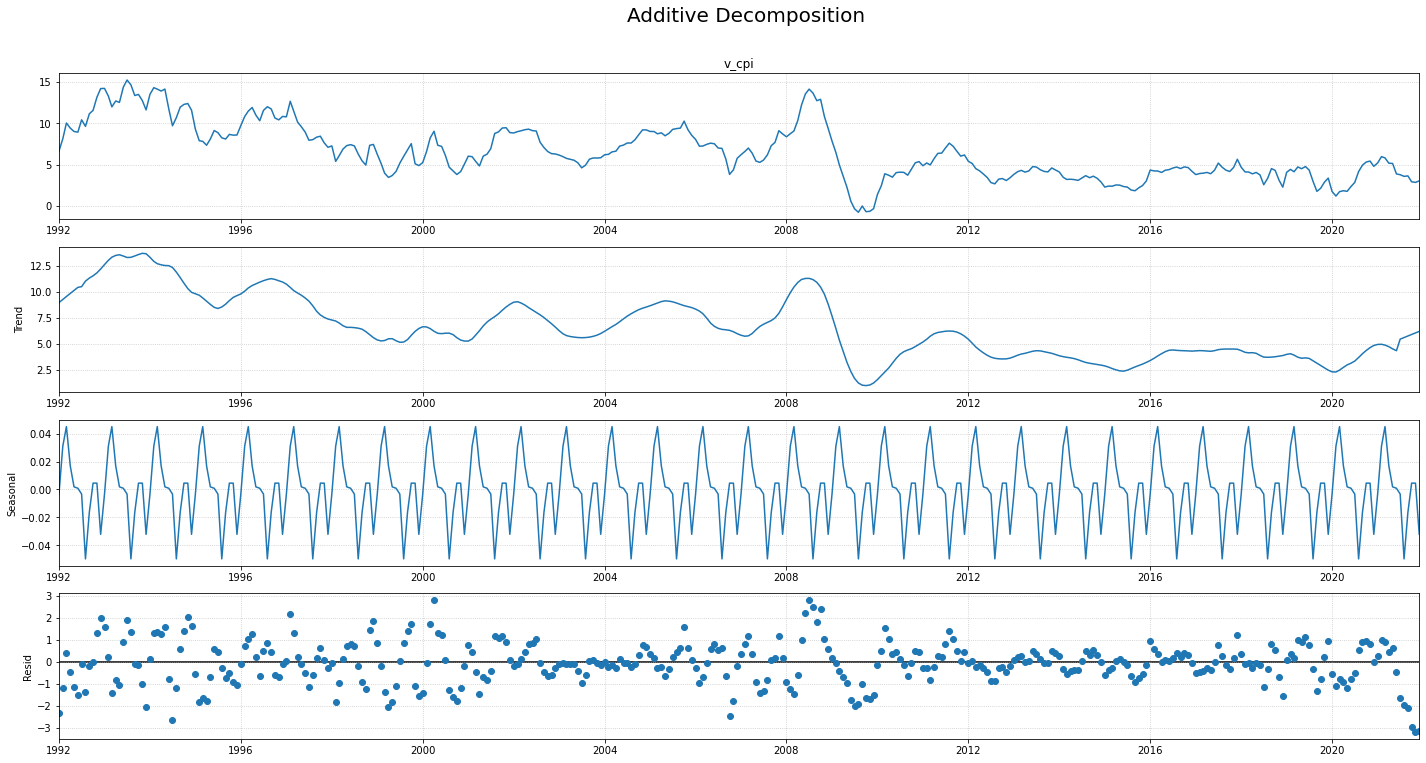

In [45]:
# # Additive Decomposition
plt.rcParams['figure.figsize'] = (20, 10);
a = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq').plot()
plt.suptitle('Additive Decomposition', x = 0.525, y = 1.055, fontsize=20)
for i in range(len(a.axes)):
    a.axes[i].grid(axis='x', alpha=0.75, linestyle=':')
    a.axes[i].grid(axis='y', alpha=0.75, linestyle=':')
plt.show()

In [11]:
decomp = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq')
df_rec = pd.concat([decomp.seasonal, decomp.trend, decomp.resid, decomp.observed], axis=1)
df_rec.columns = ['seas', 'trend', 'resid', 'actual_values']
df_rec.head()

,seas,trend,resid,actual_values
date,,,,
1947-01-01,0.149721,-4.176101,12.687797,8.661417
1947-02-01,0.136805,-3.423370,14.310186,11.023622
1947-03-01,0.078374,-2.670638,11.752570,9.160305
1947-04-01,0.045319,-1.917907,6.350199,4.477612
1947-05-01,-0.011785,-1.165175,3.366741,2.189781


In [12]:
# DataFrame with seasonally adjusted Data
inf1['inf_seasAdj'] = df_rec.resid

# IT regime dummy variable
inf1['IT_reg'] = np.zeros(len(inf1))
inf1['IT_reg']['2005-01-01':] = 1 
inf1['pce'] = PCE.pct_change(12)*100
inf1['core_pce'] = CorePCE.pct_change(12)*100
inf1['cpiUS'] = CpiUS.pct_change(12)*100

# lag creation
inf1["inf_seasAdj_l1"] = inf1['inf_seasAdj'].shift()
inf1["inf_seasAdj_l3"] = inf1['inf_seasAdj'].shift(3)
inf1["inf_seasAdj_l6"] = inf1['inf_seasAdj'].shift(6)
inf1["inf_seasAdj_l12"] = inf1['inf_seasAdj'].shift(12)
inf1["inf_seasAdj_l24"] = inf1['inf_seasAdj'].shift(24)
# drop na's
inf1.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf = inf1.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf = simdf.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf  = simdf.loc['2005-01-01':'2021-12-01']


In [13]:
# DataFrame with observed data
''' This data is for the models and tests which consider the whole period, since v_cpi is stationary when we consider 
the whole period. '''
inf2 = pd.read_csv('data/inflation.csv', delimiter=';')
inf2.index = pd.to_datetime(inf2.date, format='%d/%m/%Y')
inf2 = inf2.drop("date", axis = 1)
inf2['v_cpi'] = inf2['CPI'].pct_change(12)*100

# IT regime dummy variable
inf2['IT_reg'] = np.zeros(len(inf2))
inf2['IT_reg']['2005-01-01':] = 1 
inf2['pce'] = PCE.pct_change(12)*100
inf2['core_pce'] = CorePCE.pct_change(12)*100
inf2['cpiUS'] = CpiUS.pct_change(12)*100

# lag creation
inf2["l1"] = inf2['v_cpi'].shift()
inf2["l3"] = inf2['v_cpi'].shift(3)
inf2["l6"] = inf2['v_cpi'].shift(6)
inf2["l12"] = inf2['v_cpi'].shift(12)
inf2["l18"] = inf2['v_cpi'].shift(18)
inf2["l24"] = inf2['v_cpi'].shift(24)
# drop na's
inf2.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf2 = inf2.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf2 = inf2.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf2  = inf2.loc['2005-01-01':'2021-12-01']

# inf2.head(24)

In [14]:
# To CSV
inf1.to_csv('output/inflation_SeasAdj.csv', sep=';')
inf2.to_csv('output/inflationLags.csv', sep=';')

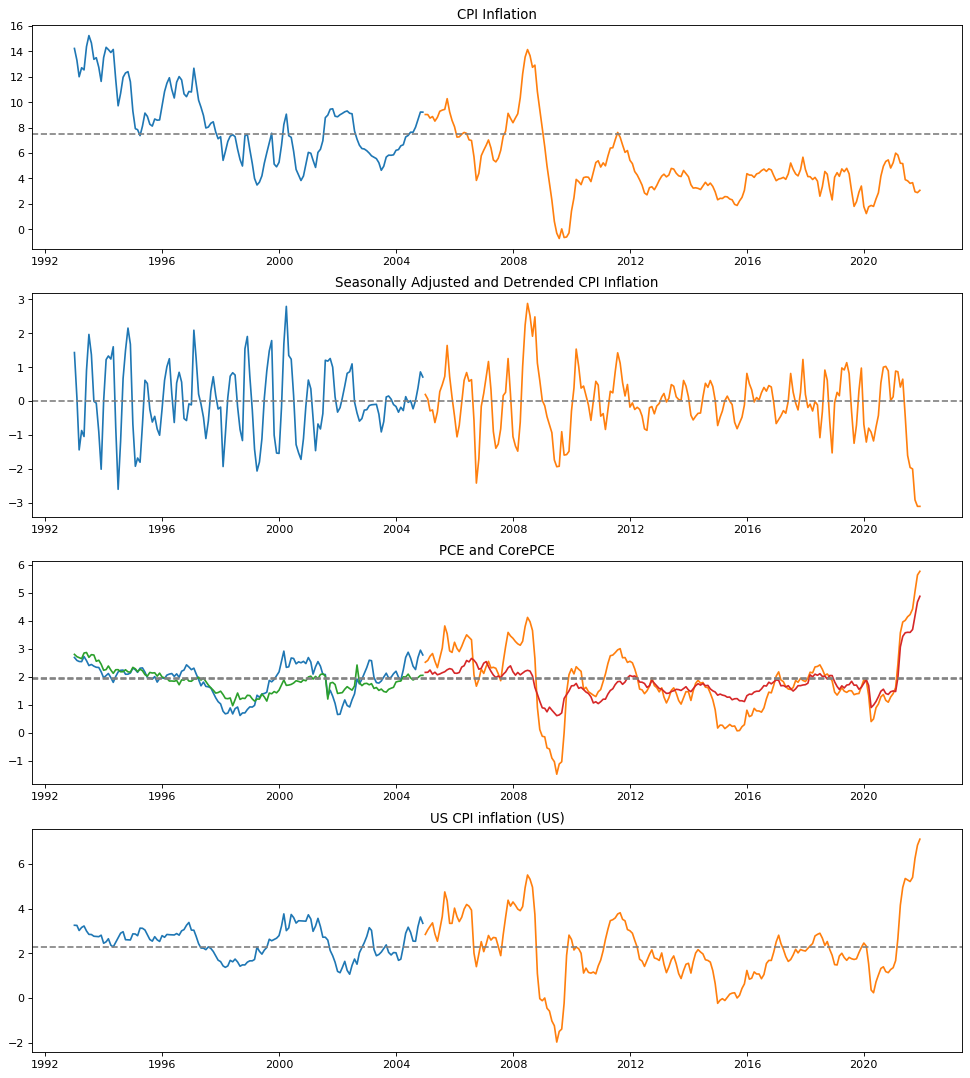

In [15]:
# Final Data to model with
fig, axes = plt.subplots(4, 1, figsize=(15,17), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

axes[2].plot(predf['pce'])
axes[2].plot(itdf['pce'])
axes[2].plot(predf['core_pce'])
axes[2].plot(itdf['core_pce'])
axes[2].set_title('PCE and CorePCE')
axes[2].axhline(y=np.mean(inf1['pce']), color='grey', linestyle='--')
axes[2].axhline(y=np.mean(inf1['core_pce']), color='grey', linestyle='--')

axes[3].plot(predf['cpiUS'])
axes[3].plot(itdf['cpiUS'])
axes[3].set_title('US CPI inflation (US)')
axes[3].axhline(y=np.mean(simdf['cpiUS']), color='grey', linestyle='--')
plt.show()


ADF Test for Stationarity on Guatemala detrended and Seasonally adjusted Inflation

In [16]:
# Whole period
adf = adfuller(simdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:1.870370093513673e-09 , whole period: Series is Stationary
p value:5.359212083582485e-05 , Pre IT period: Series is Stationary
p value:0.003422291791936745 , IT period: Series is Stationary


## Benchmark Models and Structural Break Tests

### Kontonikas (2004)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + u_{1t}$

Model 1: Using the seasonally adjusted data

In [59]:
# Whole Period
mod1_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6 + inf_seasAdj_l12', data=simdf).fit() #+ inf_seasAdj_l3 + inf_seasAdj_l6
print('Params:')
print(mod1_1.params[1:])
print('P-values:')
print(mod1_1.pvalues[1:])
print('Estimated persistence, Complete period: ',mod1_1.params[1:].sum())

Params:
inf_seasAdj_l1     0.706229
inf_seasAdj_l3    -0.258603
inf_seasAdj_l6     0.113868
inf_seasAdj_l12   -0.182637
dtype: float64
P-values:
inf_seasAdj_l1     2.992466e-49
inf_seasAdj_l3     3.100467e-12
inf_seasAdj_l6     2.514321e-03
inf_seasAdj_l12    1.013216e-07
dtype: float64
Estimated persistence, Complete period:  0.37885676433484894


Structural Break Test (CUSUM Test)

In [60]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1, alpha=0.90)

breaks_cusumolsresid(mod1_1.resid)
# We cannot reject the null hypothesis of no structural change.

(0.729043908894949, 0.6624986464217185, [(1, 1.63), (5, 1.36), (10, 1.22)])

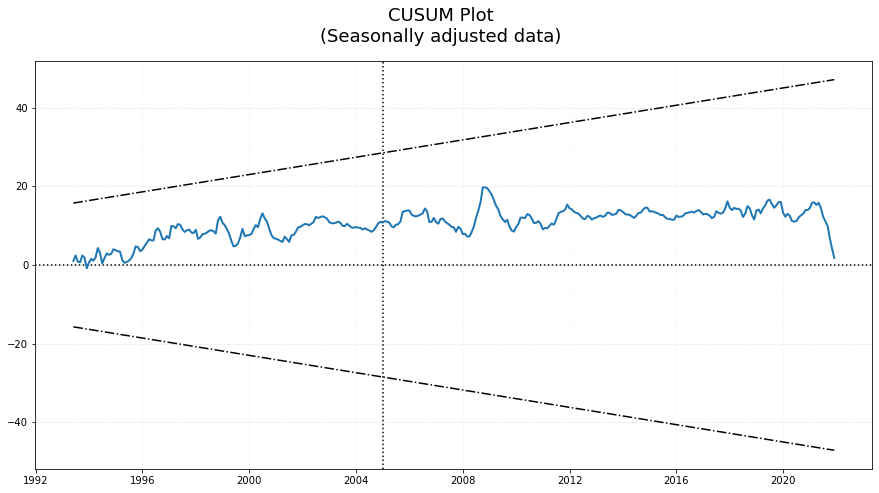

In [62]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[5:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[5:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[5:]), linewidth=2)
plt.suptitle('CUSUM Plot\n(Seasonally adjusted data)', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Model 1B: Using the observed inflation

In [20]:
# Whole Period
mod1_1B = smf.ols(formula='v_cpi ~ l1 + l3 + l6 + l12', data=simdf2).fit()
print('Params:')
print(mod1_1B.params[1:])
print('P-values:')
print(mod1_1B.pvalues[1:])
print('Estimated persistence, Complete period: ',mod1_1B.params[1:].sum())

Params:
l1     1.090500
l3    -0.179290
l6     0.078489
l12   -0.040986
dtype: float64
P-values:
l1     1.183389e-109
l3      1.119583e-05
l6      1.011624e-02
l12     3.113101e-02
dtype: float64
Estimated persistence, Complete period:  0.9487128037687321


Structural Break Test (CUSUM Test)

In [21]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1B, alpha=0.90)

breaks_cusumolsresid(mod1_1B.resid)
# We reject the null hypothesis of no structural change.

(1.706869759123615, 0.005894936043870829, [(1, 1.63), (5, 1.36), (10, 1.22)])

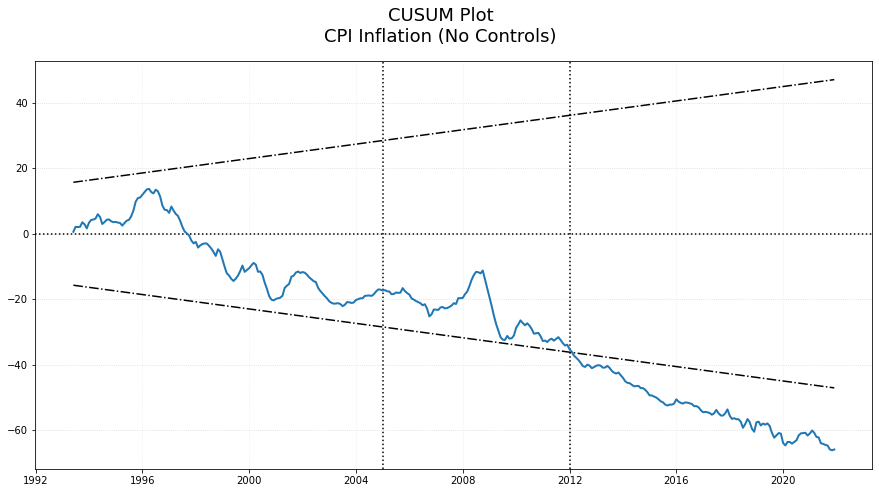

In [48]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[5:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[5:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2012-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[5:]), linewidth=2)
plt.suptitle('CUSUM Plot\nCPI Inflation (No Controls)', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Some evidence of structural break, but only after 2012. 

That is more likely to be due to the low inflation in the US after the 2008 recession.

### Kontonikas (2004) adding Controls (US inflation)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + \delta X+ u_{1t}$

Using Seasonally adjusted data

In [88]:
# Whole Period
mod1_1C = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6 + inf_seasAdj_l12 + cpiUS', data=simdf).fit() #+ inf_seasAdj_l3 + inf_seasAdj_l6
print('Params:')
print(mod1_1C.params[1:])
print('P-values:')
print(mod1_1C.pvalues[1:])
print('Estimated persistence, Complete period: ',mod1_1C.params[1:-1].sum())

Params:
inf_seasAdj_l1     0.706522
inf_seasAdj_l3    -0.258327
inf_seasAdj_l6     0.114616
inf_seasAdj_l12   -0.181626
cpiUS              0.006516
dtype: float64
P-values:
inf_seasAdj_l1     4.055253e-49
inf_seasAdj_l3     3.561790e-12
inf_seasAdj_l6     2.464767e-03
inf_seasAdj_l12    1.497857e-07
cpiUS              8.015299e-01
dtype: float64
Estimated persistence, Complete period:  0.38118404167254655


In [89]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1C, alpha=0.90)

breaks_cusumolsresid(mod1_1C.resid)
# We cannot reject the null hypothesis of no structural change.

(0.7470131665597329, 0.6321971682435428, [(1, 1.63), (5, 1.36), (10, 1.22)])

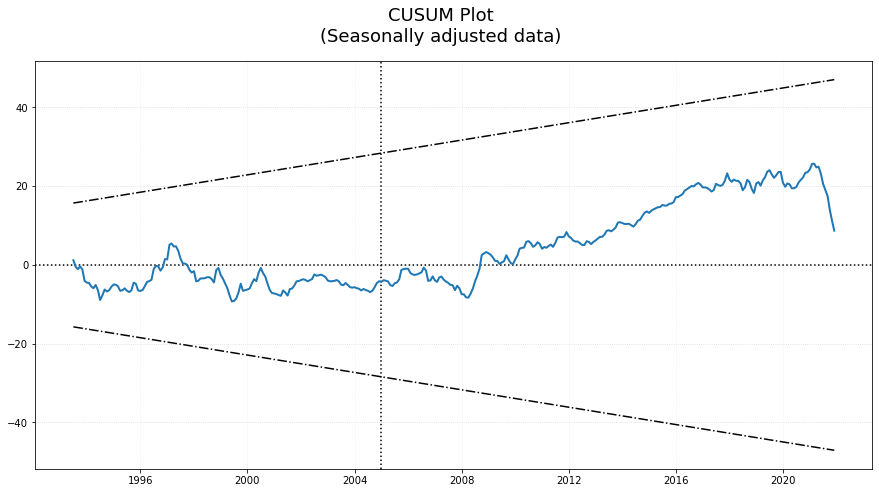

In [90]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[6:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[6:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[6:]), linewidth=2)
plt.suptitle('CUSUM Plot\n(Seasonally adjusted data)', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Using Observed Inflation

In [79]:
# Whole Period
mod1_1BC = smf.ols(formula='v_cpi ~ l1 + l3 + l6 + l12 + cpiUS', data=simdf2).fit()
print('Params:')
print(mod1_1BC.params[1:5])
print('P-values:')
print(mod1_1BC.pvalues[1:])
print('Estimated persistence, Complete period: ',mod1_1BC.params[1:5].sum())

Params:
l1     1.061227
l3    -0.176057
l6     0.085560
l12   -0.037123
dtype: float64
P-values:
l1       2.146653e-104
l3        1.186896e-05
l6        4.544500e-03
l12       4.767328e-02
cpiUS     6.556428e-04
dtype: float64
Estimated persistence, Complete period:  0.9336061201166784


Structural Break Test (CUSUM Test)

In [80]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres1BC = recursive_olsresiduals(mod1_1BC, alpha=0.90)

breaks_cusumolsresid(mod1_1BC.resid)
# We reject the null hypothesis of no structural change.

(1.4841975774246106, 0.02441544057395054, [(1, 1.63), (5, 1.36), (10, 1.22)])

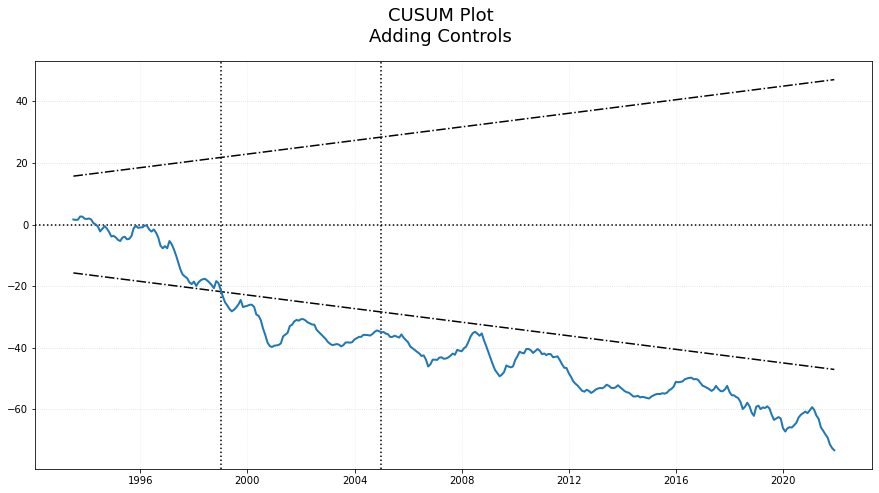

In [81]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres1BC[6][1],index=simdf2.index[6:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres1BC[6][0],index=simdf2.index[6:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('1999-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres1BC[5][1:],index=simdf2.index[6:]), linewidth=2)
plt.suptitle('CUSUM Plot\nAdding Controls', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Modeling the persistance separately in both periods using seasonally adjusted data

Model 2: Seasonally adjusted data for pre IT period

In [72]:
# Pre IT Period
mod1_2 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12 + cpiUS', data=predf).fit()
print('Params:')
print(mod1_2.params[1:5])
print('P-values:')
print(mod1_2.pvalues[1:])
print('Estimated persistence, pre IT period: ', mod1_2.params[1:5].sum())

Params:
inf_seasAdj_l1     0.597377
inf_seasAdj_l3    -0.327156
inf_seasAdj_l6     0.185037
inf_seasAdj_l12   -0.162163
dtype: float64
P-values:
inf_seasAdj_l1     4.141398e-16
inf_seasAdj_l3     6.948543e-08
inf_seasAdj_l6     4.014090e-03
inf_seasAdj_l12    3.378917e-04
cpiUS              6.370107e-01
dtype: float64
Estimated persistence, pre IT period:  0.29309460985193914


Model 3: Seasonally adjusted data for IT period


In [27]:
# IT Period
mod1_3 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12 + cpiUS', data=itdf).fit()
print('Params:')
print(mod1_3.params[1:])
print('P-values:')
print(mod1_3.pvalues[1:])
print('Estimated persistence, IT period: ', mod1_3.params[1:5].sum())



Params:
inf_seasAdj_l1     0.737119
inf_seasAdj_l3    -0.168112
inf_seasAdj_l6    -0.079332
inf_seasAdj_l12   -0.308706
cpiUS             -0.012350
dtype: float64
P-values:
inf_seasAdj_l1     2.913802e-32
inf_seasAdj_l3     5.268674e-04
inf_seasAdj_l6     9.854713e-02
inf_seasAdj_l12    1.389444e-08
cpiUS              6.131539e-01
dtype: float64
Estimated persistence, IT period:  0.18096898636526315


Persistence have decreased, with the introduction of the IT (lags significant in all models)

### Model with whole period and Dummy for IT regime

as in Kontonikas (2004)

$\pi = \gamma_0 + (\gamma_1 + \gamma_5D_t)\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + (\gamma_4 + \gamma_6D_t)\pi_{t-12} + u_{1t}$


Model 2.1 Seasonally adjusted data

In [28]:
# Whole Period
mod2_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l1*target + inf_seasAdj_l12 + inf_seasAdj_l12*target + pce', data=simdf).fit()
print('Params:')
print(mod2_1.params[1:])
print('P-values:')
print(mod2_1.pvalues[1:])

Params:
inf_seasAdj_l1            0.953919
target                   -0.002715
inf_seasAdj_l1:target    -0.064301
inf_seasAdj_l12          -0.504898
inf_seasAdj_l12:target    0.039877
pce                       0.002809
dtype: float64
P-values:
inf_seasAdj_l1            2.471961e-08
target                    9.032605e-01
inf_seasAdj_l1:target     2.173847e-02
inf_seasAdj_l12           1.911018e-03
inf_seasAdj_l12:target    1.138589e-01
pce                       9.366718e-01
dtype: float64


In [29]:
print('gamma5 + gamma6 = ', mod2_1.params[3] + mod2_1.params[5])

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance


gamma5 + gamma6 =  -0.024424270177955454


Structural Break Test (CUSUM Test)

In [30]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
# recres2 = recursive_olsresiduals(mod2_1, alpha=0.90)

breaks_cusumolsresid(mod2_1.resid)
# We cannot reject the null hypothesis of no structural change.

(0.6003375007903784, 0.8638355709011905, [(1, 1.63), (5, 1.36), (10, 1.22)])

Model 2.1B Observed data

In [31]:
# Whole Period
mod2_1B = smf.ols(formula='v_cpi ~ l1 + l1*target + l12 + l12*target + pce', data=simdf2).fit()
print('Params:')
print(mod2_1B.params[1:])
print('P-values:')
print(mod2_1B.pvalues[1:])

Params:
l1            0.974241
target        0.278586
l1:target    -0.006395
l12          -0.017963
l12:target   -0.009205
pce           0.146310
dtype: float64
P-values:
l1            2.469063e-36
target        9.866601e-03
l1:target     5.803898e-01
l12           7.702913e-01
l12:target    3.883547e-01
pce           9.909578e-04
dtype: float64


In [32]:
print('gamma5 + gamma6 = ', mod2_1B.params[3] + mod2_1B.params[5])

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance

gamma5 + gamma6 =  -0.01560010713055885


Structural Break Test (CUSUM Test)

In [33]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
# recres2 = recursive_olsresiduals(mod2_1B, alpha=0.90)

breaks_cusumolsresid(mod2_1B.resid)
# We cannot reject the null hypothesis of no structural change.

(1.0498411156874905, 0.22035195040970995, [(1, 1.63), (5, 1.36), (10, 1.22)])

### Chow Test for structural Breaks

Perfom Chow Test to check structural break in 2005 due to the IT introduction

#### Test for seasonally adjusted data

LAG 1

In [34]:
# Chow test for inflation persistance using inflation lagged 1 period (one month) (SHORT RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l1'],
                    len(predf)-1, len(predf), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance 

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 1.8067814504302555, P_value: 0.16574076007097582


(1.8067814504302555, 0.16574076007097582)

LAG 3

In [35]:
# Chow test for inflation persistance using inflation lagged 1 period (one QUARTER) 
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l3'],
                    len(predf)-1, len(predf), 0.05)

# Reject -> evidence that IT has introduced a strutural change in the inflation persistance 

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 17.31986332084388, P_value: 6.825278775490773e-08


(17.31986332084388, 6.825278775490773e-08)

LAG 6

In [36]:
# Chow test for inflation persistance using inflation lagged 1 period (one QUARTER) 
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l6'],
                    len(predf)-1, len(predf), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 2.0710826239720976, P_value: 0.12762271454582286


(2.0710826239720976, 0.12762271454582286)

LAG 12

In [37]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l12'],
                    len(predf)-1, len(predf), 0.05)

# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.1536513493873057, P_value: 0.04393665669678393


(3.1536513493873057, 0.04393665669678393)

LAG 24

In [38]:
# Chow test for inflation persistance using inflation lagged 12 periods (two year) (LONGER RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l24'],
                    len(predf)-1, len(predf), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 1.729177177760602, P_value: 0.17897341985880666


(1.729177177760602, 0.17897341985880666)

Summary for seasonally adjusted data

Lag 1  : Fail to Reject (No structural Break)<br>
Lag 3  : Reject (structural Break)<br>
Lag 6  : Fail to Reject (No structural Break)<br>
Lag 12 : Reject (structural Break)<br>
Lag 24 : Fail to Reject (No structural Break)<br>


#### Tests for observed data

We can observe more evidence when using the observed data (which is stationary considering the longer period)

Lag 1

In [39]:
# Chow test for inflation persistance using inflation lagged 1 period (one month) (SHORT RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l1'],
                    len(predf2)-1, len(predf2), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance 

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6299949420644463, P_value: 0.5332096227065113


(0.6299949420644463, 0.5332096227065113)

Lag 3

In [40]:
# Chow test for inflation persistance using inflation lagged 3 periods (one quarter) 
chow_test.chow_test(simdf2['v_cpi'], simdf2['l3'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance                    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.790284618264656, P_value: 0.02354109765226342


(3.790284618264656, 0.02354109765226342)

Lag 6

In [41]:
# Chow test for inflation persistance using inflation lagged 6 periods (two quarters) 
chow_test.chow_test(simdf2['v_cpi'], simdf2['l6'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 11.239919003142624, P_value: 1.8700982123642795e-05


(11.239919003142624, 1.8700982123642795e-05)

Lag 12

In [42]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l12'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 34.3325482472182, P_value: 2.5646151868841116e-14


(34.3325482472182, 2.5646151868841116e-14)

Lag 24

In [43]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l24'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 36.93981770062148, P_value: 2.9976021664879227e-15


(36.93981770062148, 2.9976021664879227e-15)

Summary for observed data

Lag 1  : Fail to Reject (No structural Break)<br>
Lag 3  : Reject (structural Break)<br>
Lag 6   : Reject (structural Break)<br>
Lag 12 : Reject (structural Break)<br>
Lag 24 : Reject (structural Break)<br>